In [1]:
# imports
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
visited_color = .8
current_color = .5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

actions = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down'
}

num_actions = len(actions)

epsilon = .15

In [3]:
class Maze(object):
    def __init__(self, maze, curr=(0,0)) -> None:
        self._maze = np.array(maze)
        num_rows, num_cols = self._maze.shape
        self.target = (num_rows - 1, num_cols - 1) # end goal

        self.free_cells = []
        for r in range(num_rows):
            for c in range(num_cols):
                if self._maze[r,c] == 1:
                    self.free_cells.append((r,c))
        self.free_cells.remove(self.target)
        self.reset(curr)
    
    def reset(self, curr):
        self.curr = curr
        # use a copy of original maze
        self.maze = np.copy(self._maze)
        num_rows, num_cols = self._maze.shape
        row, col = curr
        self.maze[row, col] = current_color
        self.state = (row, col, 'start')
        self.min_reward = -.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        num_rows, num_cols = self._maze.shape
        nrow, ncol, nmode = curr_row, curr_col, mode = self.state
        
        if self.maze[curr_row, curr_col] > 0:
            self.visited.add((curr_row,curr_col))
        
        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # set new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        curr_row, curr_col, mode = self.state
        nrows, ncols = self.maze.shape
        if curr_row == nrows - 1 and curr_col == ncols - 1:
            return 1
        if mode == 'blocked':
            return self.min_reward - 1
        if (curr_row, curr_col) in self.visited:
            return -.25
        if mode == 'invalid':
            return -.75
        if mode == 'valid':
            return -.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the person
        row, col, valid = self.state
        canvas[row, col] = current_color
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        curr_row, curr_col, mode = self.state
        nrows, ncols = self.maze.shape
        if curr_row == nrows-1 and curr_col == ncols-1:
            return 'win'

        return 'not_over'
    
    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape

        # check if cant move up
        if row == 0 or (row > 0 and self.maze[row - 1, col] == 0):
            actions.remove(1)

        # check if cant move down
        if row == nrows - 1 or (row < nrows - 1 and self.maze[row + 1, col] == 0):
            actions.remove(3)

        # check if cant move left
        if col == 0 or (col > 0 and self.maze[row, col - 1] == 0):
            actions.remove(0)

        # check if cant move right
        if col == ncols - 1 or (col<ncols - 1 and self.maze[row, col + 1] == 0):
            actions.remove(2)

        return actions
        
    

In [4]:
def show(maze):
    plt.grid('on')
    nrows, ncols = maze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(maze.maze)
    for row,col in maze.visited:
        canvas[row,col] = visited_color
    curr_row, curr_col, _ = maze.state
    canvas[curr_row, curr_col] = current_color   # current cell
    canvas[nrows-1, ncols-1] = 0.9 # target cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

reward= -0.04


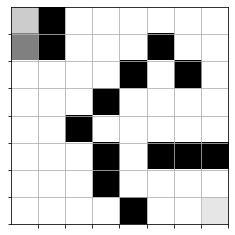

In [5]:
maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]

maze = Maze(maze)
canvas, reward, game_over = maze.act(DOWN)
print("reward=", reward)
show(maze)

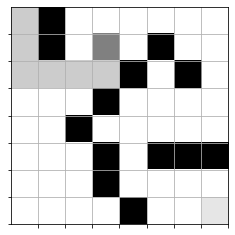

In [6]:
maze.act(DOWN)  # move down
maze.act(RIGHT)  # move right
maze.act(RIGHT)  # move right
maze.act(RIGHT)  # move right
maze.act(UP)  # move up
show(maze)

In [7]:
def play_game(model, maze, curr_cell):
    maze.reset(curr_cell)
    envstate = maze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = maze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [9]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [10]:
# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [11]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

24


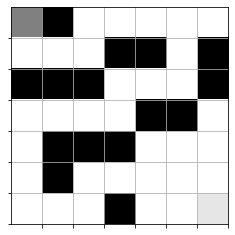

In [12]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Maze(maze)
print(qmaze.maze.size//2)
show(qmaze)

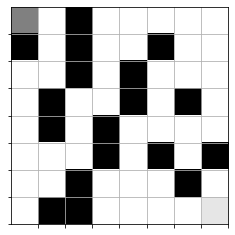

In [13]:
maze =  np.array([
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1., 1.],
    [ 0.,  1.,  0.,  1.,  1.,  0.,  1., 1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1., 1.],
    [ 1.,  0.,  1.,  1.,  0.,  1.,  0., 1.],
    [ 1.,  0.,  1.,  0.,  1.,  1.,  1., 1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  1., 0.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  0., 1.],
    [ 1.,  0.,  0.,  1.,  1.,  1.,  1., 1.]
])

qmaze = Maze(maze)
show(qmaze)

In [14]:
def plot(list, title='', x_label='', y_label=''):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    f.suptitle(title)
    ax.plot(list, label='loss')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    x = range(len(list))
    ax.legend()

In [15]:
model = build_model(maze)

epochs=1000
max_memory=8*maze.size 
data_size=50

start_time = datetime.datetime.now()

# create maze environment from array
qmaze = Maze(maze)

# setup experience object
experience = Experience(model, max_memory=max_memory)


# lists for plotting
episodes_list = []
loss_list = []
games_list = []
win_count_list = []
win_rate_list = []
time_list = []

game_history = []   # history game wins and losses
n_free_cells = len(qmaze.free_cells)
hsize = qmaze.maze.size//2   # history window size
win_rate = 0.0
imctr = 1


for epoch in range(epochs):
    epoch_start_time = datetime.datetime.now()
    loss = 0.0
    curr_cell = random.choice(qmaze.free_cells)
    qmaze.reset(curr_cell)
    game_over = False

    # get initial envstate (1d flattened canvas)
    envstate = qmaze.observe()

    n_episodes = 0
    while not game_over:
        valid_actions = qmaze.valid_actions()
        if not valid_actions: 
            break
        
        prev_envstate = envstate
        # Get next action
        if  epsilon >= np.random.rand():
            action = np.argmax(experience.predict(prev_envstate))    
        else:
            action = random.choice(valid_actions)

        # Apply action, get reward and new envstate
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            game_history.append(1)
            game_over = True
        elif game_status == 'lose':
            game_history.append(0)
            game_over = True
        else:
            game_over = False

        # Store episode (experience)
        episode = [prev_envstate, action, reward, envstate, game_over]
        experience.remember(episode)
        n_episodes += 1

        # Train neural network model
        inputs, targets = experience.get_data(data_size=data_size)
        h = model.fit(inputs, targets, epochs=8, batch_size=16, verbose=0)

        # calculate loss
        loss = model.evaluate(inputs, targets, verbose=0)

    if len(game_history) > hsize:
        win_rate = sum(game_history[-hsize:]) / hsize

    dt = datetime.datetime.now() - start_time
    epoch_time = datetime.datetime.now() - epoch_start_time
    t = format_time(dt.total_seconds())
    # template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
    # print(template.format(epoch, epochs-1, loss, n_episodes, sum(game_history), win_rate, t))
    print(f'Epoch: {epoch}/{epochs}-1 | Loss: {loss} | Episodes: {n_episodes} | Win count: {sum(game_history)} | Win rate: {win_rate} | time: {t}')
    
    loss_list.append(loss)
    episodes_list.append(n_episodes)
    games_list.append(len(game_history))
    win_count_list.append(sum(game_history))
    win_rate_list.append(win_rate)
    time_list.append(epoch_time.total_seconds())

    # we simply check if training has exhausted all free cells and if in all
    # cases the agent won
    if win_rate > 0.9 : epsilon = 0.05
    if completion_check(model, qmaze) and sum( game_history[-hsize:]) == hsize:
        print(f"Reached 100% win rate at epoch: {epoch}")
        break


print("epochs: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))

KeyboardInterrupt: 

34


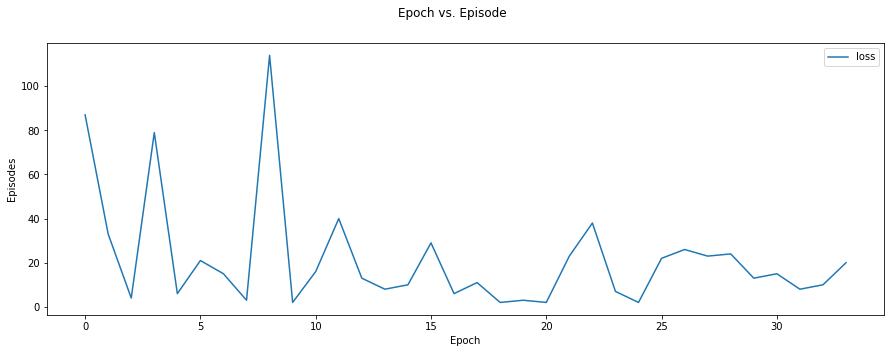

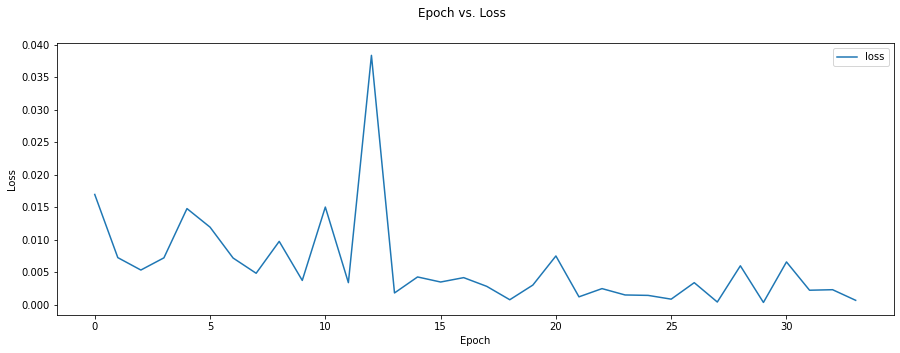

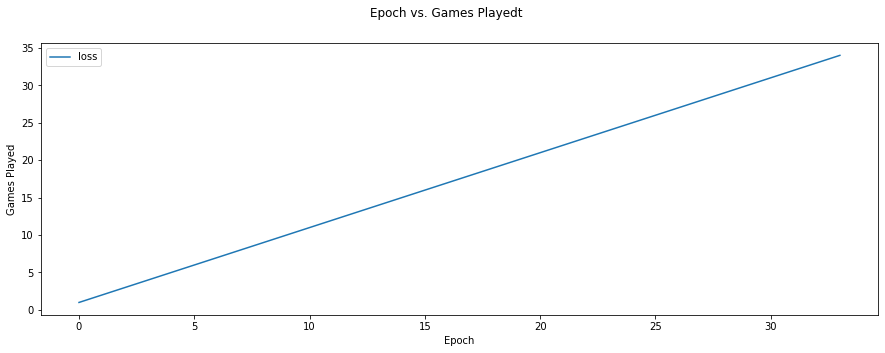

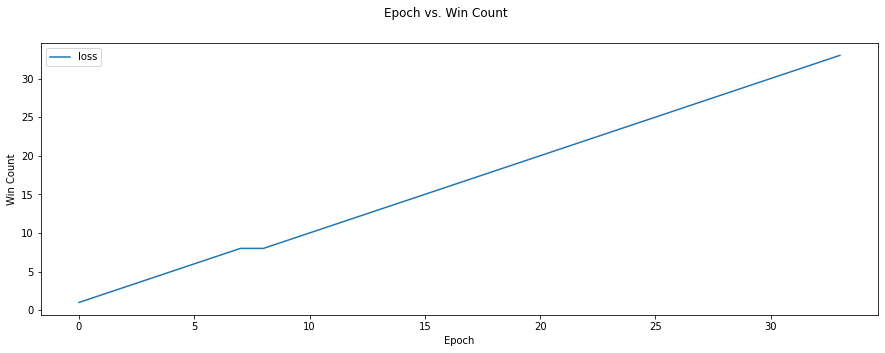

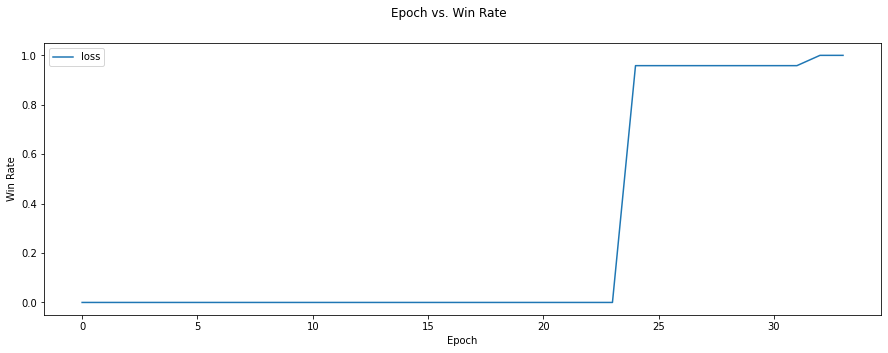

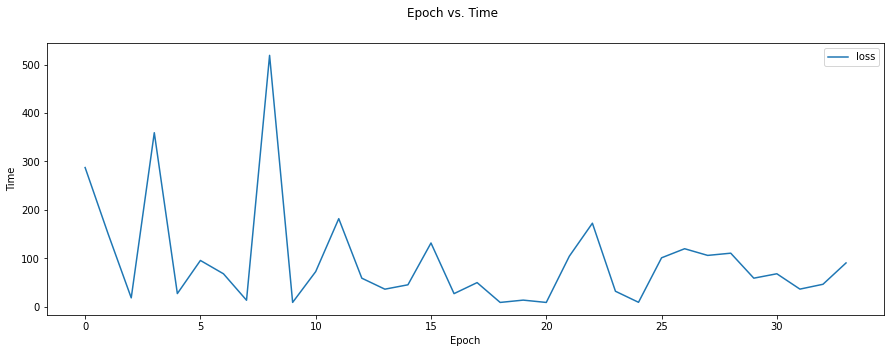

In [ ]:
# plotting

plot(episodes_list,'Epoch vs. Episode', 'Epoch', 'Episodes')
plot(loss_list,'Epoch vs. Loss', 'Epoch', 'Loss')
plot(games_list,'Epoch vs. Games Playedt', 'Epoch', 'Games Played')
plot(win_count_list,'Epoch vs. Win Count', 'Epoch', 'Win Count')
plot(win_rate_list,'Epoch vs. Win Rate', 'Epoch', 'Win Rate')
plot(time_list,'Epoch vs. Time', 'Epoch', 'Time')
